## Setup and Configuration
This initial block sets up the environment, defines file paths, and specifies the validation scans and model versions to be analyzed.

In [1]:
from pipeline.paths import Directories, Files
import os
import torch
import numpy as np
import gc
import matplotlib.pyplot as plt
# from sklearn.isotonic import IsotonicRegression

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
if torch.cuda.is_available():
    CUDA_DEVICE = torch.device("cuda:0")
    print(f"CUDA is available. Using device: {CUDA_DEVICE}")
else:
    print("CUDA is not available. Please check your PyTorch installation. Using CPU instead.")
    CUDA_DEVICE = torch.device("cpu")

PHASE = '7'
DATA_VERSION = '13'


# Base directory
WORK_ROOT = "D:/NoahSilverberg/ngCBCT"

# NSG_CBCT Path where the raw matlab data is stored
NSG_CBCT_PATH = "D:/MitchellYu/NSG_CBCT"

# Directory with all files specific to this phase/data version
PHASE_DATAVER_DIR = os.path.join(
    WORK_ROOT, f"phase{PHASE}", f"DS{DATA_VERSION}"
)

DIRECTORIES = Directories(
    # mat_projections_dir=os.path.join(NSG_CBCT_PATH, "data/prj/HF/mat"),
    # pt_projections_dir=os.path.join(WORK_ROOT, "prj_pt"),
    # projections_aggregate_dir=os.path.join(PHASE_DATAVER_DIR, "aggregates", "projections"),
    # projections_model_dir=os.path.join(PHASE_DATAVER_DIR, "models", "projections"),
    # projections_results_dir=os.path.join(PHASE_DATAVER_DIR, "results", "projections"),
    # projections_gated_dir=os.path.join(WORK_ROOT, "gated", "prj_mat"),
    reconstructions_dir=os.path.join(PHASE_DATAVER_DIR, "reconstructions"),
    reconstructions_gated_dir=os.path.join(WORK_ROOT, "gated", "fdk_recon"),
    # reconstructions_dir=os.path.join("H:\\", "Public", "Noah", "reconstructions"),
    # reconstructions_gated_dir=os.path.join("H:\\", "Public", "Noah", "gated", "fdk_recon"),
    # images_aggregate_dir=os.path.join(PHASE_DATAVER_DIR, "aggregates", "images"),
    # images_model_dir=os.path.join(PHASE_DATAVER_DIR, "models", "images"),
    # images_results_dir=os.path.join(PHASE_DATAVER_DIR, "results", "images"),
)

FILES = Files(DIRECTORIES)

VAL_SCANS = [('02', '01') , ('02', '02'), ('16', '01'), ('16', '02'), ('22', '01')] # , ('22', '02')]
# VAL_SCANS = [('08', '01'), ('10', '01'), ('14', '01'), ('14', '02'), ('15', '01'), ('20', '01')]

SCAN_TYPE = 'HF'
MODEL_VERSIONS = ['MK7_MCDROPOUT_30_pct']
PASSTHROUGH_COUNT = 30 # use None for multiple models -- only use this for one model for MC dropout

CUDA is available. Using device: cuda:0


## Data Loading
This block gathers the file paths for the model's reconstructions (50 passes for MC Dropout) and the corresponding ground truth reconstructions.

In [2]:
recon_paths_dict = {}
recon_names_dict = {}
gt_paths_dict = {}

for patient, scan in VAL_SCANS:
    print(f"Processing patient {patient}, scan {scan}")
    recon_paths = []
    recon_names = []
    if PASSTHROUGH_COUNT is None:
        for model_version in MODEL_VERSIONS:
            recon_path = FILES.get_recon_filepath(model_version, patient, scan, SCAN_TYPE, gated=False)
            recon_paths.append(recon_path)
            recon_names.append(model_version)
    else:
        for i in range(PASSTHROUGH_COUNT):
            recon_path = FILES.get_recon_filepath(MODEL_VERSIONS[0], patient, scan, SCAN_TYPE, gated=False, passthrough_num=i)
            recon_paths.append(recon_path)
            recon_names.append(f"Passthrough {i+1}")

    gt_path = FILES.get_recon_filepath('fdk', patient, scan, SCAN_TYPE, gated=True)
    gt_paths_dict[(patient, scan)] = gt_path

    recon_paths_dict[(patient, scan)] = recon_paths
    recon_names_dict[(patient, scan)] = recon_names

Processing patient 02, scan 01
Processing patient 02, scan 02
Processing patient 16, scan 01
Processing patient 16, scan 02
Processing patient 22, scan 01


## Analysis Loop
The main loop iterates through each scan. For each scan, it loads all 50 reconstruction passes, calculates the mean (prediction) and standard deviation (uncertainty), and then performs several analyses to evaluate the quality of the uncertainty estimates.


Processing reconstructions for patient 02, scan 01
Loaded 30 reconstructions for patient 02, scan 01


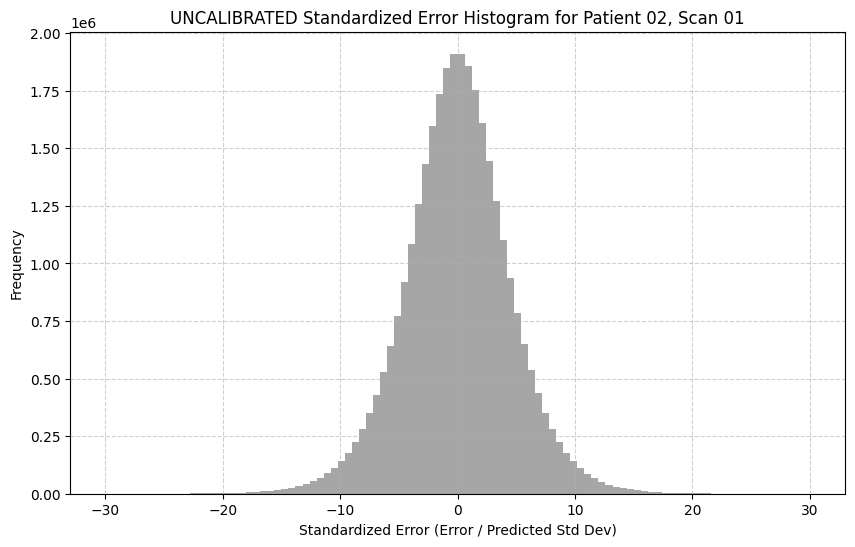

Patient 02, Scan 01 - UNCALIBRATED Coverage:
  Percent with abs standardized error < 1: 19.83% (Expected for Gaussian: ~68%)
  Percent with abs standardized error < 2: 38.08% (Expected for Gaussian: ~95%)
  Percent with abs standardized error < 3: 53.73% (Expected for Gaussian: ~99.7%)


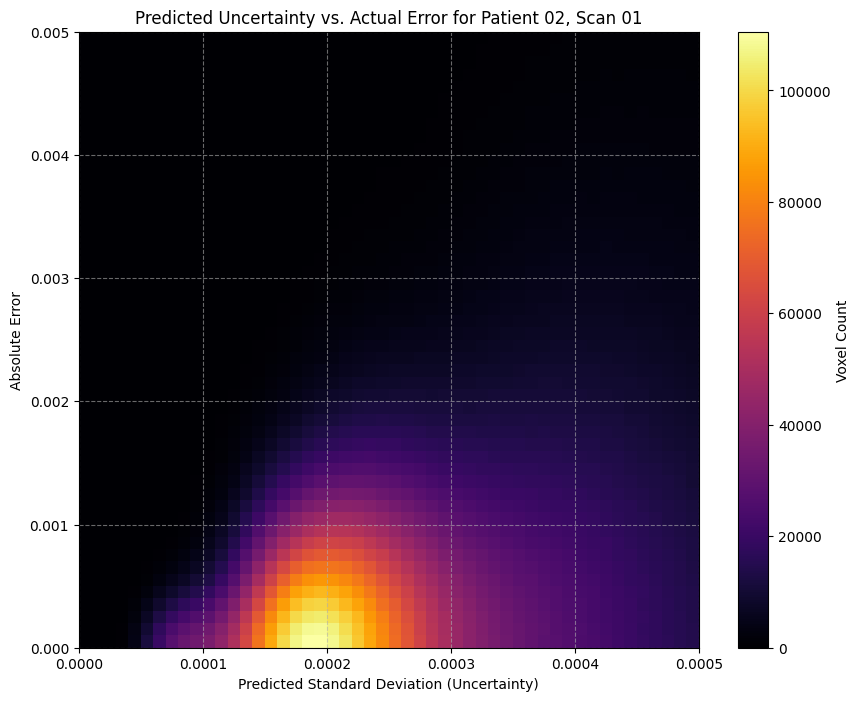

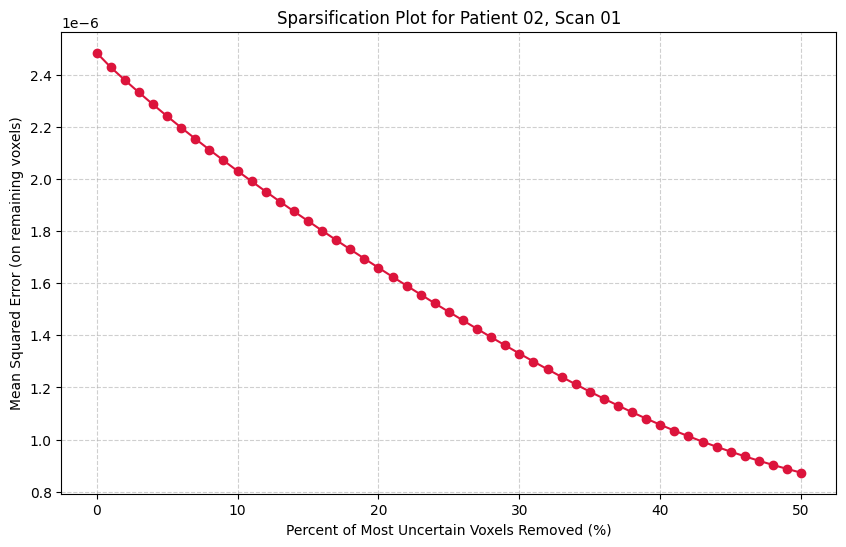


--- Quantitative Tuning Metrics for Patient 02, Scan 01 ---
  Spearman's Rank Correlation: 0.4037 (Higher is better)
  Area Under Sparsification Curve (AUSC): 7.722206e-07 (Lower is better)

--- Calibration Results ---


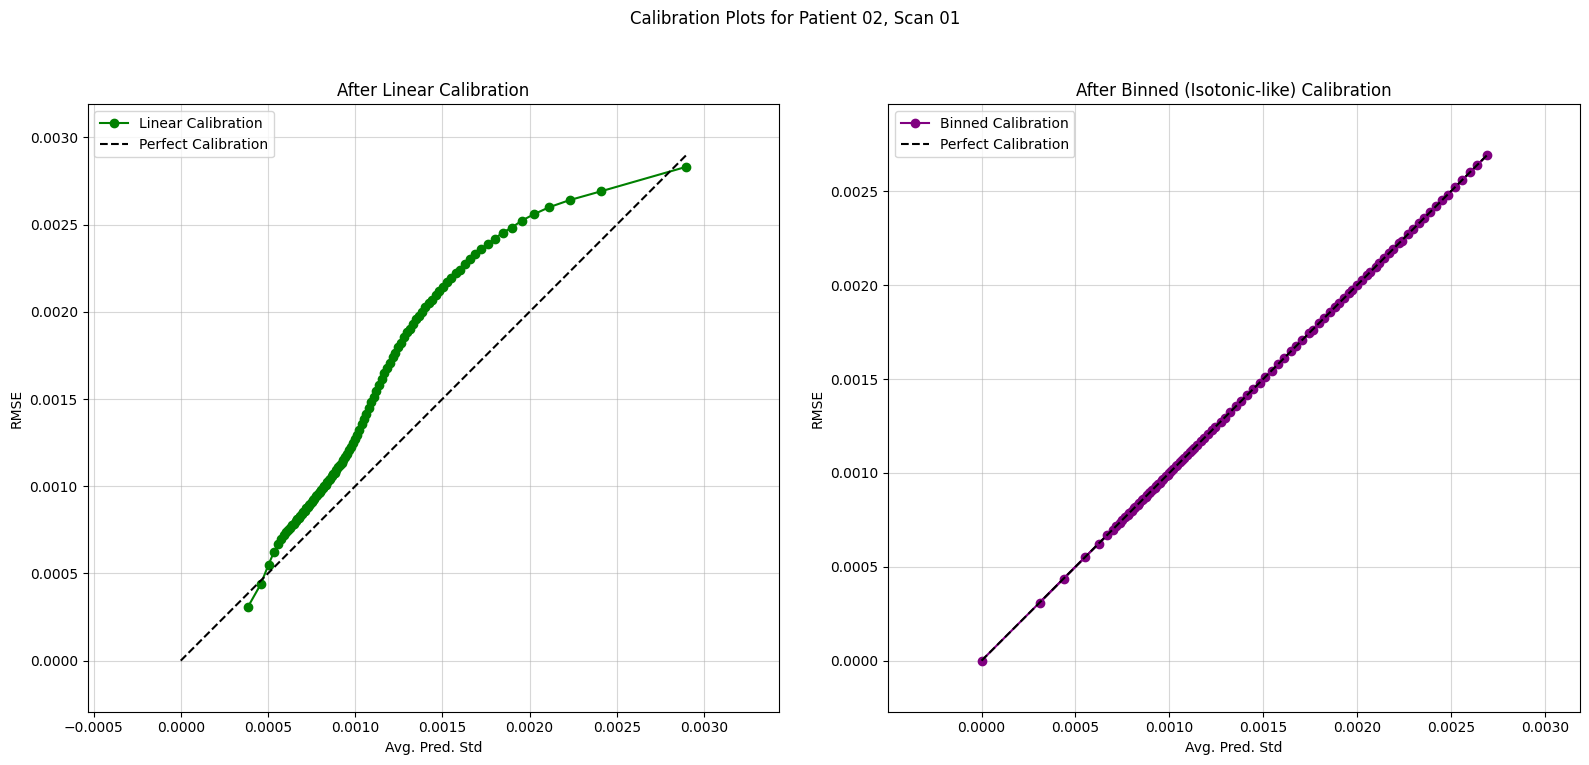

--- Final Calibrated Metrics for Patient 02, Scan 01 ---
  Coverage (Ideal is ~68%):
    [Linear]   Percent of errors within 1 calibrated sigma: 60.57%
    [Binned]   Percent of errors within 1 calibrated sigma: 71.49%
  Calibrated Negative Log-Likelihood (Lower is better):
    [Linear]   NLL: -6.0538
    [Binned]   NLL: -6.1366

Processing reconstructions for patient 02, scan 02
Loaded 30 reconstructions for patient 02, scan 02


In [ ]:
# Now go through each patient and scan, load the reconstructions
# calclate the mean and std (pixel-wise) and the error from GT
for (patient, scan), recon_paths in recon_paths_dict.items():
    print(f"\nProcessing reconstructions for patient {patient}, scan {scan}")
    
    # Load ground truth
    gt_path = gt_paths_dict[(patient, scan)]
    gt_recon = torch.load(gt_path).cpu().numpy()
    
    # Initialize lists to hold reconstructions
    reconstructions = []
    
    for recon_path in recon_paths:
        recon = torch.load(recon_path).cpu().numpy()
        reconstructions.append(recon)

    print(f"Loaded {len(reconstructions)} reconstructions for patient {patient}, scan {scan}")
    
    # Convert to numpy array for easier manipulation
    reconstructions = np.array(reconstructions)
    
    # --- Basic Calculations ---
    # Calculate mean and std across the first axis (across models or passthroughs)
    mean_recon = np.mean(reconstructions, axis=0)
    std_recon = np.std(reconstructions, axis=0)
    
    # Calculate error from ground truth
    error = mean_recon - gt_recon
    
    # Efficiently create a circular mask in the last two dimensions
    z, y, x = gt_recon.shape
    yy, xx = np.ogrid[:y, :x]
    center = np.array([y // 2, x // 2])
    radius = 225
    dist_from_center = np.sqrt((yy - center[0])**2 + (xx - center[1])**2)
    slice_mask = dist_from_center <= radius
    mask = np.broadcast_to(slice_mask, gt_recon.shape)
    
    flat_std = std_recon[mask].flatten()
    flat_error = error[mask].flatten()
    flat_abs_error = np.abs(flat_error)
    flat_squared_error = flat_error**2

    # Clean up memory
    del reconstructions, mean_recon, std_recon, error, gt_recon
    gc.collect()

    # --- Analysis 1: Standardized Error Histogram (Your Original Analysis) ---
    standardized_error = flat_error / (flat_std + 1e-8)
    plt.figure(figsize=(10, 6))
    plt.hist(standardized_error, bins=100, color='gray', alpha=0.7, range=(-30, 30))
    plt.title(f'UNCALIBRATED Standardized Error Histogram for Patient {patient}, Scan {scan}')
    plt.xlabel('Standardized Error (Error / Predicted Std Dev)')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    percent_within_1 = np.mean(np.abs(standardized_error) < 1) * 100
    percent_within_2 = np.mean(np.abs(standardized_error) < 2) * 100
    percent_within_3 = np.mean(np.abs(standardized_error) < 3) * 100
    print(f"Patient {patient}, Scan {scan} - UNCALIBRATED Coverage:")
    print(f"  Percent with abs standardized error < 1: {percent_within_1:.2f}% (Expected for Gaussian: ~68%)")
    print(f"  Percent with abs standardized error < 2: {percent_within_2:.2f}% (Expected for Gaussian: ~95%)")
    print(f"  Percent with abs standardized error < 3: {percent_within_3:.2f}% (Expected for Gaussian: ~99.7%)")

    # --- Analysis 2 & 3: Plots for Hyperparameter Tuning (Visual) ---
    plt.figure(figsize=(10, 8))
    plt.hist2d(flat_std, flat_abs_error, bins=50, cmap='inferno', range=[[0, 0.0005], [0, 0.005]])
    plt.xlim(0, 0.0005)
    plt.ylim(0, 0.005)
    plt.colorbar(label='Voxel Count')
    plt.title(f'Predicted Uncertainty vs. Actual Error for Patient {patient}, Scan {scan}')
    plt.xlabel('Predicted Standard Deviation (Uncertainty)')
    plt.ylabel('Absolute Error')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    sorted_indices = np.argsort(flat_std)
    sorted_squared_error = flat_squared_error[sorted_indices]
    fractions_removed = np.linspace(0, 0.5, 51)
    mse_remaining = np.zeros_like(fractions_removed)
    for i, frac in enumerate(fractions_removed):
        num_to_keep = int((1 - frac) * len(sorted_squared_error))
        mse_remaining[i] = np.mean(sorted_squared_error[:num_to_keep]) if num_to_keep > 0 else 0
    plt.figure(figsize=(10, 6))
    plt.plot(fractions_removed * 100, mse_remaining, 'o-', color='crimson')
    plt.title(f'Sparsification Plot for Patient {patient}, Scan {scan}')
    plt.xlabel('Percent of Most Uncertain Voxels Removed (%)')
    plt.ylabel('Mean Squared Error (on remaining voxels)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    # --- Analysis 4: Quantitative Tuning Metrics (New Section) ---
    # These single numbers help decide which dropout rate is better by focusing on correlation
    # and ranking, ignoring the bad scaling of the raw uncertainty.
    
    # Spearman's Rank Correlation: Measures if high uncertainty ranks correspond to high error ranks. Higher is better.
    from scipy.stats import spearmanr
    spearman_corr, _ = spearmanr(flat_std, flat_abs_error)
    
    # Area Under Sparsification Curve (AUSC): Quantifies the sparsification plot. Lower is better.
    ausc = np.trapz(mse_remaining, fractions_removed)

    print(f"\n--- Quantitative Tuning Metrics for Patient {patient}, Scan {scan} ---")
    print(f"  Spearman's Rank Correlation: {spearman_corr:.4f} (Higher is better)")
    print(f"  Area Under Sparsification Curve (AUSC): {ausc:.6e} (Lower is better)")
    
    # --- Analysis 5: Post-Hoc Uncertainty Calibration (Updated Section) ---
    print("\n--- Calibration Results ---")

    # Method 1: Linear Calibration
    p_linear = np.polyfit(flat_std, flat_abs_error, 1)
    calibrated_std_linear = np.polyval(p_linear, flat_std)
    calibrated_std_linear[calibrated_std_linear < 0] = 0

    # Method 2: Binned (Isotonic-like) Calibration (No sklearn needed)
    # This method learns the average error for different levels of predicted uncertainty.
    num_bins_calib = 100
    # Sort data by predicted std to make binning efficient
    sort_indices_calib = np.argsort(flat_std)
    sorted_std_calib = flat_std[sort_indices_calib]
    sorted_sq_err_calib = flat_squared_error[sort_indices_calib]
    
    # Create bins with roughly equal numbers of points
    bin_boundaries = np.quantile(sorted_std_calib, np.linspace(0, 1, num_bins_calib + 1))
    
    calibrated_std_binned = np.zeros_like(flat_std)
    
    for i in range(num_bins_calib):
        lower = bin_boundaries[i]
        upper = bin_boundaries[i+1]
        # Find all voxels that fall into this uncertainty bin
        in_bin = (flat_std >= lower) & (flat_std <= upper)
        if np.any(in_bin):
            # Calculate the true average error (RMSE) for all voxels in this bin
            true_rmse_in_bin = np.sqrt(np.mean(flat_squared_error[in_bin]))
            # Assign this true RMSE as the calibrated uncertainty for all those voxels
            calibrated_std_binned[in_bin] = true_rmse_in_bin

    # --- Visualize the Calibrated Results ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'Calibration Plots for Patient {patient}, Scan {scan}')

    num_bins_plot = 100 # Can use fewer bins for a cleaner plot

    # Linear Calibration Plot (using Quantile Bins for plotting)
    bin_limits_lin = np.quantile(calibrated_std_linear, np.linspace(0, 1, num_bins_plot + 1))
    rmse_per_bin_lin = [np.sqrt(np.mean(flat_squared_error[(calibrated_std_linear >= ll) & (calibrated_std_linear < ul)])) if np.any((calibrated_std_linear >= ll) & (calibrated_std_linear < ul)) else 0 for ll, ul in zip(bin_limits_lin[:-1], bin_limits_lin[1:])]
    mean_std_per_bin_lin = [np.mean(calibrated_std_linear[(calibrated_std_linear >= ll) & (calibrated_std_linear < ul)]) if np.any((calibrated_std_linear >= ll) & (calibrated_std_linear < ul)) else 0 for ll, ul in zip(bin_limits_lin[:-1], bin_limits_lin[1:])]
    ax1.plot(mean_std_per_bin_lin, rmse_per_bin_lin, 'o-', label='Linear Calibration', color='green')
    lims1 = [0, max(np.max(mean_std_per_bin_lin), np.max(rmse_per_bin_lin))]
    ax1.plot(lims1, lims1, 'k--', label='Perfect Calibration')
    ax1.set_title('After Linear Calibration'); ax1.set_xlabel('Avg. Pred. Std'); ax1.set_ylabel('RMSE'); ax1.legend(); ax1.grid(True, alpha=0.5); ax1.axis('equal');

    # Binned Calibration Plot (using Quantile Bins for plotting)
    bin_limits_binned = np.quantile(calibrated_std_binned, np.linspace(0, 1, num_bins_plot + 1))
    rmse_per_bin_binned = [np.sqrt(np.mean(flat_squared_error[(calibrated_std_binned >= ll) & (calibrated_std_binned < ul)])) if np.any((calibrated_std_binned >= ll) & (calibrated_std_binned < ul)) else 0 for ll, ul in zip(bin_limits_binned[:-1], bin_limits_binned[1:])]
    mean_std_per_bin_binned = [np.mean(calibrated_std_binned[(calibrated_std_binned >= ll) & (calibrated_std_binned < ul)]) if np.any((calibrated_std_binned >= ll) & (calibrated_std_binned < ul)) else 0 for ll, ul in zip(bin_limits_binned[:-1], bin_limits_binned[1:])]
    ax2.plot(mean_std_per_bin_binned, rmse_per_bin_binned, 'o-', label='Binned Calibration', color='purple')
    lims2 = [0, max(np.max(mean_std_per_bin_binned), np.max(rmse_per_bin_binned))]
    ax2.plot(lims2, lims2, 'k--', label='Perfect Calibration')
    ax2.set_title('After Binned (Isotonic-like) Calibration'); ax2.set_xlabel('Avg. Pred. Std'); ax2.set_ylabel('RMSE'); ax2.legend(); ax2.grid(True, alpha=0.5); ax2.axis('equal');
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

    # --- Final Metrics After Calibration ---
    # Now that the uncertainty is scaled correctly, we can calculate meaningful absolute metrics.
    calibrated_standardized_error_linear = flat_error / (calibrated_std_linear + 1e-8)
    percent_within_1_linear = np.mean(np.abs(calibrated_standardized_error_linear) < 1) * 100
    
    calibrated_standardized_error_binned = flat_error / (calibrated_std_binned + 1e-8)
    percent_within_1_binned = np.mean(np.abs(calibrated_standardized_error_binned) < 1) * 100

    # Calibrated Negative Log-Likelihood (NLL)
    # This is a key metric. A lower NLL indicates a better overall model (accuracy + uncertainty).
    # Use the calibrated variance (std^2) for this calculation.
    nll_linear = np.mean(0.5 * flat_squared_error / (calibrated_std_linear**2 + 1e-8) + 0.5 * np.log(calibrated_std_linear**2 + 1e-8))
    nll_binned = np.mean(0.5 * flat_squared_error / (calibrated_std_binned**2 + 1e-8) + 0.5 * np.log(calibrated_std_binned**2 + 1e-8))

    print(f"--- Final Calibrated Metrics for Patient {patient}, Scan {scan} ---")
    print(f"  Coverage (Ideal is ~68%):")
    print(f"    [Linear]   Percent of errors within 1 calibrated sigma: {percent_within_1_linear:.2f}%")
    print(f"    [Binned]   Percent of errors within 1 calibrated sigma: {percent_within_1_binned:.2f}%")
    print(f"  Calibrated Negative Log-Likelihood (Lower is better):")
    print(f"    [Linear]   NLL: {nll_linear:.4f}")
    print(f"    [Binned]   NLL: {nll_binned:.4f}")
    
    # Clean up memory
    del flat_std, flat_error, flat_abs_error, flat_squared_error, standardized_error
    del calibrated_std_linear, calibrated_std_binned
    gc.collect()

# Analysis 2: Calibration then look at hold-out

Total scans: 5
Calibration Set (for learning the map): [('02', '02'), ('02', '01')]
Evaluation Set (for testing the map): [('22', '01'), ('16', '02'), ('16', '01')]

--- Aggregating data from calibration set... ---
  Loading data for calibration from: Patient 02, Scan 02
  Loading data for calibration from: Patient 02, Scan 01

--- Training calibration models... ---
Learned Linear Calibration: y = 2.78x + 0.0002
Learned Binned Calibration map with 100 bins.

--- Evaluating calibration on hold-out evaluation set... ---

--- Results for Patient 22, Scan 01 (Evaluation Set) ---


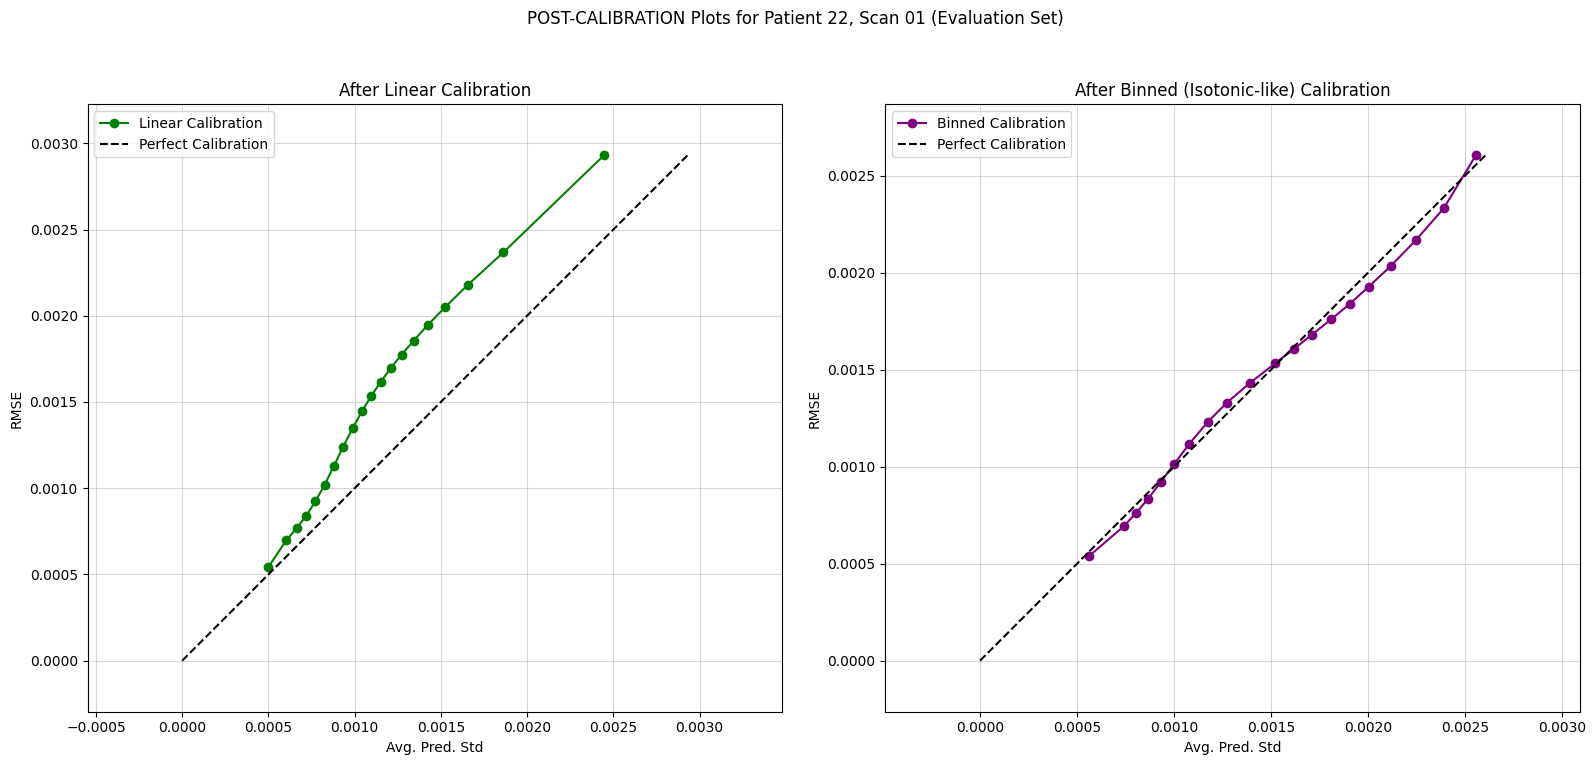

  Coverage on Evaluation Set (Ideal is ~68%):
    [Linear]   Percent of errors within 1 calibrated sigma: 60.17%
    [Binned]   Percent of errors within 1 calibrated sigma: 71.88%
  Calibrated Negative Log-Likelihood on Evaluation Set (Lower is better):
    [Linear]   NLL: -6.0143
    [Binned]   NLL: -6.0947

--- Results for Patient 16, Scan 02 (Evaluation Set) ---


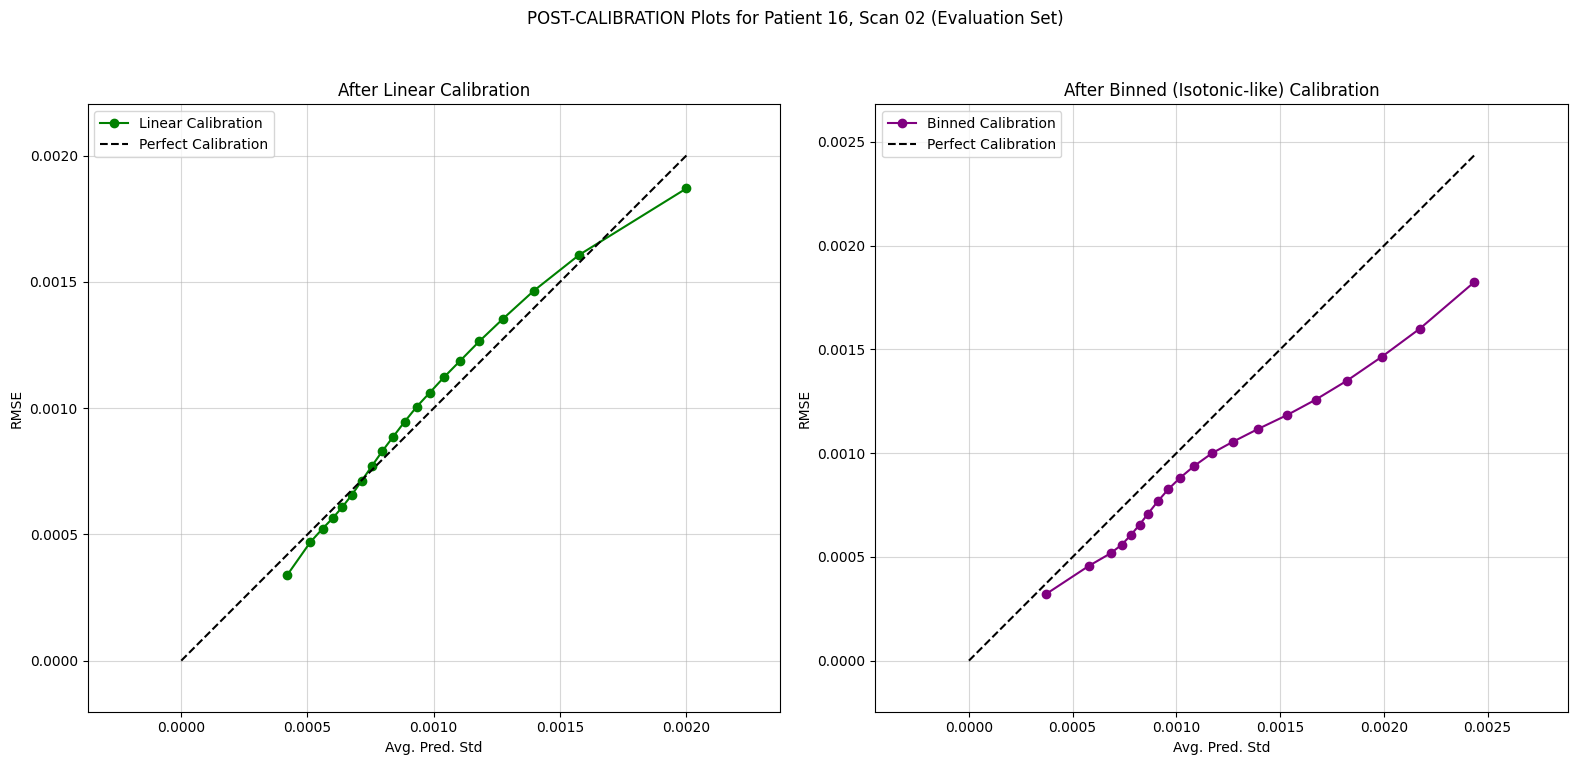

  Coverage on Evaluation Set (Ideal is ~68%):
    [Linear]   Percent of errors within 1 calibrated sigma: 70.75%
    [Binned]   Percent of errors within 1 calibrated sigma: 80.81%
  Calibrated Negative Log-Likelihood on Evaluation Set (Lower is better):
    [Linear]   NLL: -6.5315
    [Binned]   NLL: -6.4886

--- Results for Patient 16, Scan 01 (Evaluation Set) ---


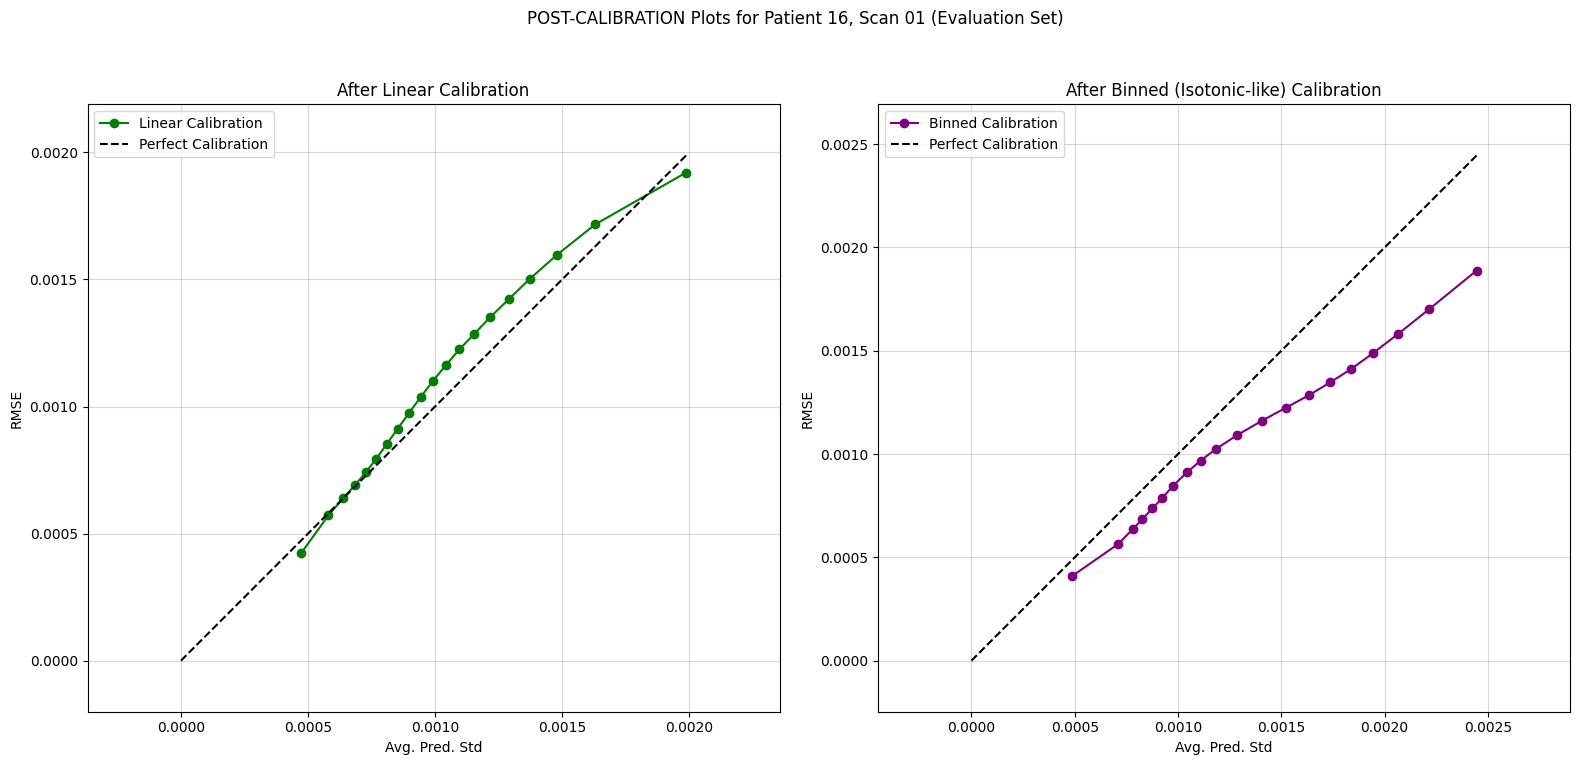

  Coverage on Evaluation Set (Ideal is ~68%):
    [Linear]   Percent of errors within 1 calibrated sigma: 68.33%
    [Binned]   Percent of errors within 1 calibrated sigma: 79.60%
  Calibrated Negative Log-Likelihood on Evaluation Set (Lower is better):
    [Linear]   NLL: -6.3825
    [Binned]   NLL: -6.3493


In [3]:
import random
from scipy.stats import spearmanr
import numpy as np
import matplotlib.pyplot as plt
import gc

# --- 1. Create a Train/Test Split for Calibration ---
# We will randomly split the validation scans into two halves.
# We'll learn the calibration map on the first half and evaluate it on the second.

# Shuffle the list of validation scans to ensure a random split
random.shuffle(VAL_SCANS)
split_point = len(VAL_SCANS) // 2
calibration_scans = VAL_SCANS[:split_point]
evaluation_scans = VAL_SCANS[split_point:]

print(f"Total scans: {len(VAL_SCANS)}")
print(f"Calibration Set (for learning the map): {calibration_scans}")
print(f"Evaluation Set (for testing the map): {evaluation_scans}")


# --- 2. Learn the Calibration Map from the Calibration Set ---
# We will aggregate the raw uncertainty and error from all scans in the calibration set.

all_calib_std = []
all_calib_abs_error = []
all_calib_squared_error = []

print("\n--- Aggregating data from calibration set... ---")
for (patient, scan) in calibration_scans:
    print(f"  Loading data for calibration from: Patient {patient}, Scan {scan}")
    
    # Load ground truth and reconstructions
    gt_path = gt_paths_dict[(patient, scan)]
    gt_recon = torch.load(gt_path).cpu().numpy()
    
    reconstructions = []
    recon_paths = recon_paths_dict[(patient, scan)]
    for recon_path in recon_paths:
        reconstructions.append(torch.load(recon_path).cpu().numpy())
    
    reconstructions = np.array(reconstructions)
    
    # Calculate basic stats
    mean_recon = np.mean(reconstructions, axis=0)
    std_recon = np.std(reconstructions, axis=0)
    error = mean_recon - gt_recon
    
    # Apply mask
    z, y, x = gt_recon.shape
    yy, xx = np.ogrid[:y, :x]
    center = np.array([y // 2, x // 2])
    radius = 225
    dist_from_center = np.sqrt((yy - center[0])**2 + (xx - center[1])**2)
    slice_mask = dist_from_center <= radius
    mask = np.broadcast_to(slice_mask, gt_recon.shape)
    
    # Append flattened arrays to our master lists
    all_calib_std.append(std_recon[mask].flatten())
    all_calib_abs_error.append(np.abs(error[mask].flatten()))
    all_calib_squared_error.append((error[mask].flatten())**2)

    # Clean up
    del reconstructions, mean_recon, std_recon, error, gt_recon
    gc.collect()

# Concatenate all data into single large arrays
calib_flat_std = np.concatenate(all_calib_std)
calib_flat_abs_error = np.concatenate(all_calib_abs_error)
calib_flat_squared_error = np.concatenate(all_calib_squared_error)

print("\n--- Training calibration models... ---")

# Train Method 1: Linear Calibration Model
# Fits a line: y = a*x + b, mapping raw std dev to absolute error.
linear_calib_coeffs = np.polyfit(calib_flat_std, calib_flat_abs_error, 1)
print(f"Learned Linear Calibration: y = {linear_calib_coeffs[0]:.2f}x + {linear_calib_coeffs[1]:.4f}")


# Train Method 2: Binned (Isotonic-like) Calibration Model
# This model learns the average error for different levels of predicted uncertainty.
num_bins_calib = 100
bin_boundaries = np.quantile(calib_flat_std, np.linspace(0, 1, num_bins_calib + 1))
binned_calib_rmse_map = np.zeros(num_bins_calib)

for i in range(num_bins_calib):
    lower = bin_boundaries[i]
    upper = bin_boundaries[i+1]
    in_bin = (calib_flat_std >= lower) & (calib_flat_std <= upper)
    if np.any(in_bin):
        binned_calib_rmse_map[i] = np.sqrt(np.mean(calib_flat_squared_error[in_bin]))

# The binned calibration model is now stored in `bin_boundaries` and `binned_calib_rmse_map`
print("Learned Binned Calibration map with 100 bins.")

# Clean up calibration data
del all_calib_std, all_calib_abs_error, all_calib_squared_error
del calib_flat_std, calib_flat_abs_error, calib_flat_squared_error
gc.collect()


# --- 3. Evaluate the Calibration on the Hold-Out Evaluation Set ---

print("\n--- Evaluating calibration on hold-out evaluation set... ---")
for (patient, scan) in evaluation_scans:
    print(f"\n--- Results for Patient {patient}, Scan {scan} (Evaluation Set) ---")
    
    # Load ground truth and reconstructions for the evaluation scan
    gt_path = gt_paths_dict[(patient, scan)]
    gt_recon = torch.load(gt_path).cpu().numpy()
    
    reconstructions = []
    recon_paths = recon_paths_dict[(patient, scan)]
    for recon_path in recon_paths:
        reconstructions.append(torch.load(recon_path).cpu().numpy())
        
    reconstructions = np.array(reconstructions)
    
    # Calculate basic stats
    mean_recon = np.mean(reconstructions, axis=0)
    std_recon = np.std(reconstructions, axis=0)
    error = mean_recon - gt_recon
    
    # Apply mask
    z, y, x = gt_recon.shape
    yy, xx = np.ogrid[:y, :x]
    center = np.array([y // 2, x // 2])
    radius = 225
    dist_from_center = np.sqrt((yy - center[0])**2 + (xx - center[1])**2)
    slice_mask = dist_from_center <= radius
    mask = np.broadcast_to(slice_mask, gt_recon.shape)
    
    eval_flat_std = std_recon[mask].flatten()
    eval_flat_error = error[mask].flatten()
    eval_flat_squared_error = error[mask]**2

    # --- Apply the PREVIOUSLY LEARNED calibration maps ---
    
    # Apply Linear map
    calibrated_std_linear = np.polyval(linear_calib_coeffs, eval_flat_std)
    calibrated_std_linear[calibrated_std_linear < 0] = 0

    # Apply Binned map
    # Find which bin each data point belongs to
    bin_indices = np.searchsorted(bin_boundaries, eval_flat_std, side='right') - 1
    bin_indices = np.clip(bin_indices, 0, num_bins_calib - 1) # Handle edge cases
    calibrated_std_binned = binned_calib_rmse_map[bin_indices]
    
    # --- Visualize and Quantify the Calibrated Results ---
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f'POST-CALIBRATION Plots for Patient {patient}, Scan {scan} (Evaluation Set)')
    
    # Linear Calibration Plot
    num_bins_plot = 20
    bin_limits_lin = np.quantile(calibrated_std_linear, np.linspace(0, 1, num_bins_plot + 1))
    rmse_per_bin_lin = [np.sqrt(np.mean(eval_flat_squared_error[(calibrated_std_linear >= ll) & (calibrated_std_linear < ul)])) if np.any((calibrated_std_linear >= ll) & (calibrated_std_linear < ul)) else 0 for ll, ul in zip(bin_limits_lin[:-1], bin_limits_lin[1:])]
    mean_std_per_bin_lin = [np.mean(calibrated_std_linear[(calibrated_std_linear >= ll) & (calibrated_std_linear < ul)]) if np.any((calibrated_std_linear >= ll) & (calibrated_std_linear < ul)) else 0 for ll, ul in zip(bin_limits_lin[:-1], bin_limits_lin[1:])]
    ax1.plot(mean_std_per_bin_lin, rmse_per_bin_lin, 'o-', label='Linear Calibration', color='green')
    lims1 = [0, max(np.max(mean_std_per_bin_lin), np.max(rmse_per_bin_lin))]
    ax1.plot(lims1, lims1, 'k--', label='Perfect Calibration')
    ax1.set_title('After Linear Calibration'); ax1.set_xlabel('Avg. Pred. Std'); ax1.set_ylabel('RMSE'); ax1.legend(); ax1.grid(True, alpha=0.5); ax1.axis('equal');

    # Binned Calibration Plot
    bin_limits_binned = np.quantile(calibrated_std_binned, np.linspace(0, 1, num_bins_plot + 1))
    rmse_per_bin_binned = [np.sqrt(np.mean(eval_flat_squared_error[(calibrated_std_binned >= ll) & (calibrated_std_binned < ul)])) if np.any((calibrated_std_binned >= ll) & (calibrated_std_binned < ul)) else 0 for ll, ul in zip(bin_limits_binned[:-1], bin_limits_binned[1:])]
    mean_std_per_bin_binned = [np.mean(calibrated_std_binned[(calibrated_std_binned >= ll) & (calibrated_std_binned < ul)]) if np.any((calibrated_std_binned >= ll) & (calibrated_std_binned < ul)) else 0 for ll, ul in zip(bin_limits_binned[:-1], bin_limits_binned[1:])]
    ax2.plot(mean_std_per_bin_binned, rmse_per_bin_binned, 'o-', label='Binned Calibration', color='purple')
    lims2 = [0, max(np.max(mean_std_per_bin_binned), np.max(rmse_per_bin_binned))]
    ax2.plot(lims2, lims2, 'k--', label='Perfect Calibration')
    ax2.set_title('After Binned (Isotonic-like) Calibration'); ax2.set_xlabel('Avg. Pred. Std'); ax2.set_ylabel('RMSE'); ax2.legend(); ax2.grid(True, alpha=0.5); ax2.axis('equal');
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

    # Final Calibrated Metrics
    calibrated_standardized_error_linear = eval_flat_error / (calibrated_std_linear + 1e-8)
    percent_within_1_linear = np.mean(np.abs(calibrated_standardized_error_linear) < 1) * 100
    
    calibrated_standardized_error_binned = eval_flat_error / (calibrated_std_binned + 1e-8)
    percent_within_1_binned = np.mean(np.abs(calibrated_standardized_error_binned) < 1) * 100

    nll_linear = np.mean(0.5 * eval_flat_squared_error / (calibrated_std_linear**2 + 1e-8) + 0.5 * np.log(calibrated_std_linear**2 + 1e-8))
    nll_binned = np.mean(0.5 * eval_flat_squared_error / (calibrated_std_binned**2 + 1e-8) + 0.5 * np.log(calibrated_std_binned**2 + 1e-8))

    print(f"  Coverage on Evaluation Set (Ideal is ~68%):")
    print(f"    [Linear]   Percent of errors within 1 calibrated sigma: {percent_within_1_linear:.2f}%")
    print(f"    [Binned]   Percent of errors within 1 calibrated sigma: {percent_within_1_binned:.2f}%")
    print(f"  Calibrated Negative Log-Likelihood on Evaluation Set (Lower is better):")
    print(f"    [Linear]   NLL: {nll_linear:.4f}")
    print(f"    [Binned]   NLL: {nll_binned:.4f}")
    
    del reconstructions, mean_recon, std_recon, error, gt_recon, eval_flat_std, eval_flat_error, eval_flat_squared_error
    del calibrated_std_linear, calibrated_std_binned
    gc.collect()